In [6]:
from evotorch import Problem
from evotorch.decorators import vectorized
from evotorch.algorithms import CMAES, SNES
from evotorch.logging import StdOutLogger, PandasLogger
import torch
import treescope

treescope.register_as_default()
treescope.basic_interactive_setup()

In [7]:
@vectorized
def sphere(x: torch.Tensor) -> torch.Tensor:
    print(x.shape)
    return torch.sum(x.pow(2),)

In [12]:
problem = Problem("min", sphere, solution_length=100, initial_bounds=(-1, 1))
searcher = SNES(problem, stdev_init=5)
logger = StdOutLogger(searcher)
pandas_logger = PandasLogger(searcher)

[2024-12-31 18:35:31] INFO     <93647> evotorch.core: Instance of `Problem` (id:6087801024) -- The `dtype` for the problem's decision variables is set as torch.float32
[2024-12-31 18:35:31] INFO     <93647> evotorch.core: Instance of `Problem` (id:6087801024) -- `eval_dtype` (the dtype of the fitnesses and evaluation data) is set as torch.float32
[2024-12-31 18:35:31] INFO     <93647> evotorch.core: Instance of `Problem` (id:6087801024) -- The `device` of the problem is set as cpu
[2024-12-31 18:35:31] INFO     <93647> evotorch.core: Instance of `Problem` (id:6087801024) -- The number of actors that will be allocated for parallelized evaluation is 0


In [13]:
searcher.run(1000)

torch.Size([17, 100])


ValueError: The method `set_evals(...)` received a tensor with 0 dimensions. Since the problem at hand has only one objective, 1-dimensional or 2-dimensional tensors are acceptable, but not 0-dimensional ones.

In [5]:
progress = pandas_logger.to_dataframe()
fprogress.mean_eval.plot()

NameError: name 'fprogress' is not defined

In [1]:
import numpy as np
import torch
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler
from PIL import Image
from scipy import integrate
from diffusion_pt import diffusion_sample

model_id = "stable-diffusion-v1-5/stable-diffusion-v1-5"
# scheduler = DPMSolverMultistepScheduler.from_pretrained(
#     model_id,
#     subfolder="scheduler",
#     algorithm_type="dpmsolver++",
#     use_karras_sigmas=True,
#     use_safetensors=True,
# )
pipeline = DiffusionPipeline.from_pretrained(
    model_id,
    # scheduler=scheduler,
    use_safetensors=True,
).to("mps")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [2]:
sample_fn = diffusion_sample(pipeline, ["dog"], 10, torch.Generator(device="mps"), guidance_scale=7.5, batch_size=1)

In [12]:
img = sample_fn()

  0%|          | 0/11 [00:00<?, ?it/s]

In [11]:
from diffusers.utils import pt_to_pil
from fitness_fn import brightness

In [14]:
img_cat = torch.cat([img, img], dim=0)

In [15]:
brightness(img_cat)

(2, 512, 512)


np.float64(0.4755451277190564)

In [16]:
hsv_img = pt_to_pil(img)[0].convert("HSV")

In [47]:
h, s, v = hsv_img.split()

In [64]:
amount = 1000
v = Image.fromarray((np.array(hsv_img.split()[-1], dtype=np.float64) + amount).clip(0, 255).astype(np.uint8))

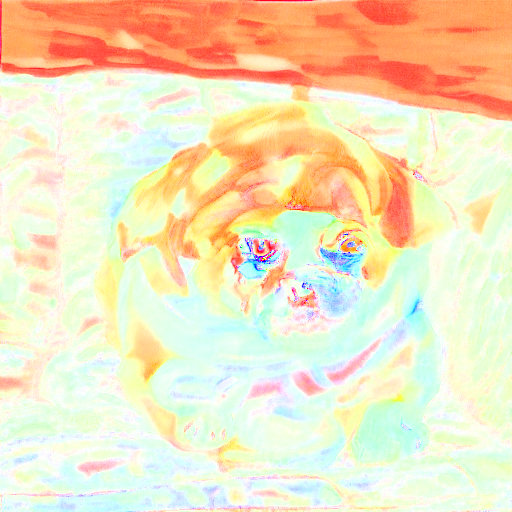

In [65]:
Image.merge("HSV", [h, s, v]).convert("RGB")

In [20]:
torch.tensor(np.array(hsv_img)).permute(2, 0, 1)

tensor([[[  7,  18,  21,  ...,  20,  19,  17],
         [  4,  12,  19,  ...,  18,  20,  17],
         [246,   2,  16,  ...,  19,  20,  17],
         ...,
         [ 70, 191, 109,  ...,  42,  42,  42],
         [ 68, 170, 131,  ...,  31,  56,  42],
         [ 99, 148, 102,  ...,  53,  50,  33]],

        [[187, 191, 120,  ..., 162, 160, 144],
         [183, 192, 123,  ..., 164, 156, 153],
         [180, 188, 131,  ..., 159, 147, 164],
         ...,
         [ 54,  12,  32,  ...,  22,  13,  44],
         [ 27,   4,  29,  ...,  31,  23,  40],
         [ 14,  33,  36,  ...,  42,  37,  87]],

        [[ 49,  64, 155,  ..., 144, 141, 138],
         [ 43,  61, 157,  ..., 150, 155, 143],
         [ 34,  42, 145,  ..., 152, 163, 141],
         ...,
         [ 42,  40,  95,  ...,  67,  73,  74],
         [ 47,  54,  96,  ...,  96,  98,  88],
         [ 54,  46,  85,  ...,  90,  74,  85]]], dtype=torch.uint8)

In [18]:
from transformers import pipeline
from PIL import Image
import requests

In [34]:
image_classifier = pipeline(task="zero-shot-image-classification", model="google/siglip-base-patch16-224")

Device set to use mps:0


In [37]:
# load image
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

# inference
candidate_labels = ["dog", "not dog"]
outputs = image_classifier([image], candidate_labels=candidate_labels)
print(outputs)
outputs = [{"score": round(output["score"], 4), "label": output["label"] } for output in outputs]
print(outputs)

[[{'score': 6.970228241698351e-06, 'label': 'not dog'}, {'score': 6.989532153056643e-07, 'label': 'dog'}]]


TypeError: list indices must be integers or slices, not str

In [31]:
from PIL import Image
import requests

from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

inputs = processor(text=["not dog", "dog"], images=image, return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities
print(probs)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


tensor([[0.9098, 0.0902]], grad_fn=<SoftmaxBackward0>)


In [38]:
for output in outputs[0]:
    if output["label"] == "dog":
        print(output["score"])

{'score': 6.970228241698351e-06, 'label': 'not dog'}
{'score': 6.989532153056643e-07, 'label': 'dog'}
